# Custom map simulations

In this tutorial we will build a simulation from scratch.

We start by defining a `Band` that will determine our array's sensitivity to different spectra. We then generate an array by specifying a field of view, which will be populated by evenly-spaced beams of the given band.

In [1]:
import maria
from maria.instrument import Band

f090 = Band(
    center=90e9,  # in Hz
    width=20e9,  # in Hz
    NET_RJ=40e-6,  # in K sqrt(s)
    knee=1e0,    # in Hz
    gain_error=5e-2)

f150 = Band(
    center=150e9, 
    width=30e9, 
    NET_RJ=60e-6, 
    knee=1e0, 
    gain_error=5e-2)


We next define an array config, which specifies how detectors will be distributed on the focal plane. In this case, we supply our two bands as the `bands` argument, which will generate an array of multichroic detectors (for monochroic detectors, we would supply e.g. `"bands": [f090]`). The resolution of each detector is determined by frequency of the band and the `primary_size` parameter. The number of detectors is determined by filling up the specified `field_of_view` with detector beams, with a relative spacing determined by the `beam_spacing` parameter.

Instrument(1 array)
├ arrays:
│             n      FOV baseline        bands polarized
│  array1  1798  0.4957°      0 m  [f090,f150]     False
│ 
└ bands:
      name   center   width    η         NEP      NET_RJ         NET_CMB     FWHM
   0  f090   90 GHz  20 GHz  0.5  5.445 aW√s  40 uK_RJ√s  49.13 uK_CMB√s  0.5832’
   1  f150  150 GHz  30 GHz  0.5  12.25 aW√s  60 uK_RJ√s    104 uK_CMB√s  0.3499’


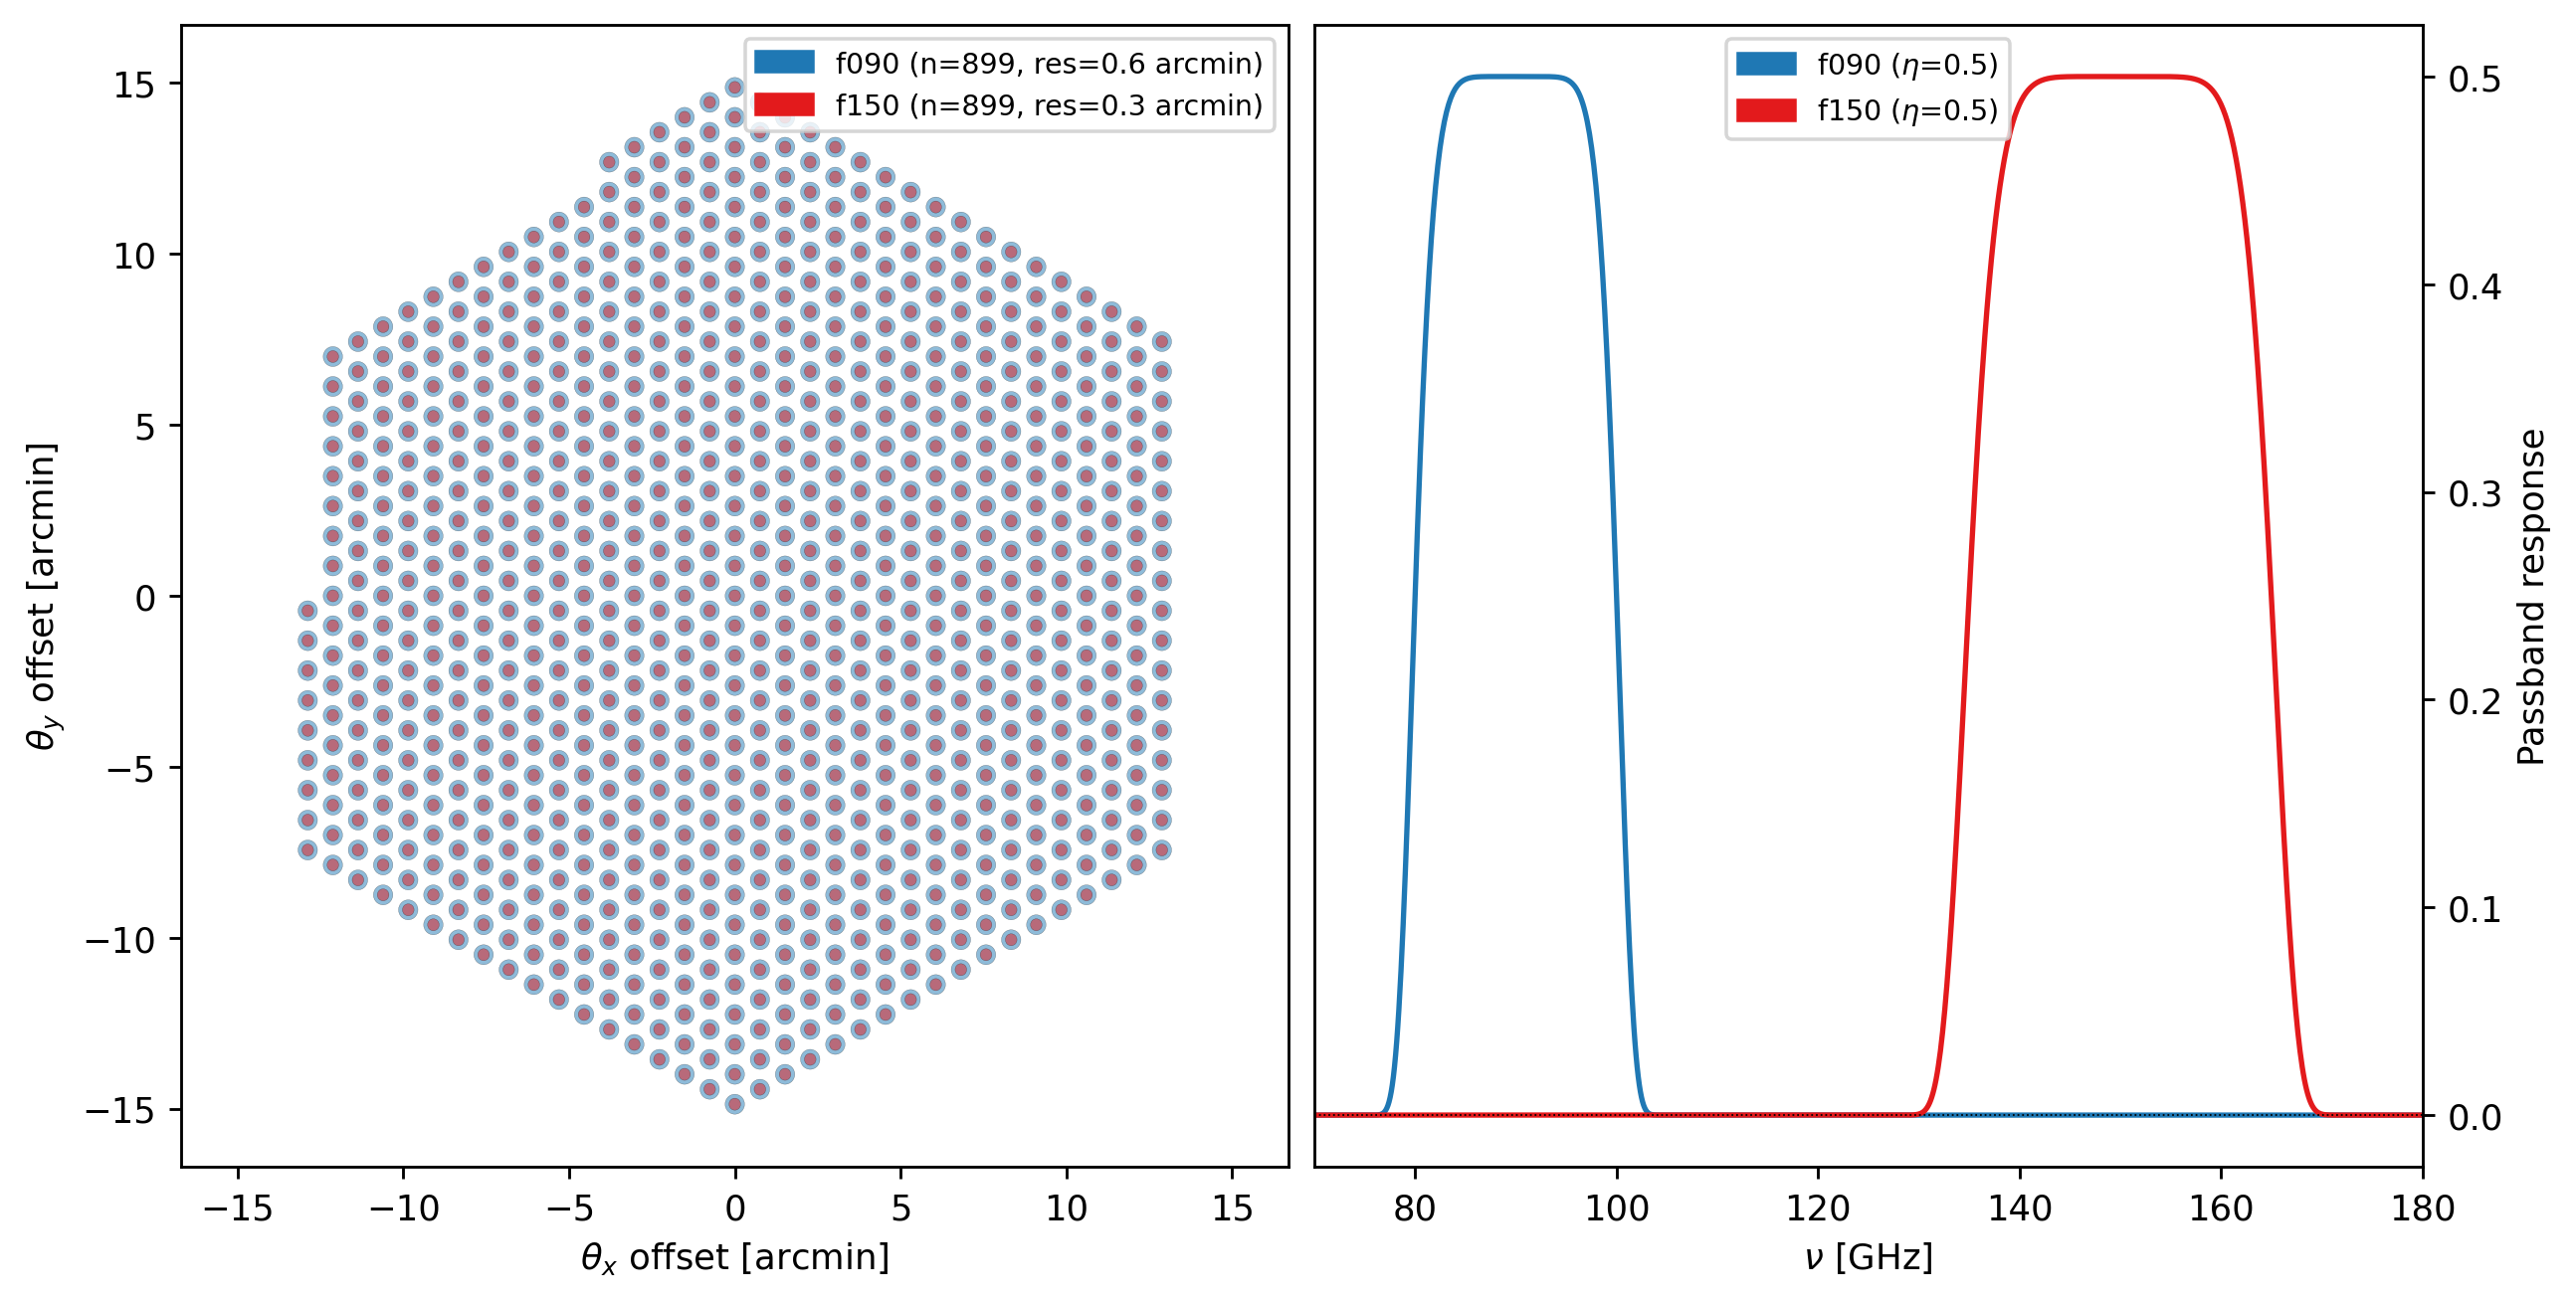

In [2]:
array = {"field_of_view": 0.5, 
         "beam_spacing": 1.5,
         "primary_size": 25, 
         "bands": [f090, f150]}

instrument = maria.get_instrument(array=array)

print(instrument)
instrument.plot()

The `Site` defines the observing location, as well as the weather conditions. ``maria`` knows about a bunch of astronomical observing sites (to see them, run `print(maria.site_data)`); we can instantiate them using the `get_site` function. We can modify the site by passing kwargs to the ``get_site`` function, like changing its `altitude` (which will affect the vertical profile of different atmospheric parameters). 

Site:
  region: chajnantor
  timezone: America/Santiago
  location:
    longitude: 67°45’17.28” W
    latitude:  23°01’45.84” S
    altitude: 5065 m
  seasonal: True
  diurnal: True


2025-11-23 21:34:44.520 INFO: Fetching https://github.com/thomaswmorris/maria-data/raw/master/world_heightmap.h5


Downloading:   0%|                | 0.00/7.34M [00:00<?, ?B/s]

Downloading: 100%|████████████████| 7.34M/7.34M [00:00<00:00, 165MB/s]

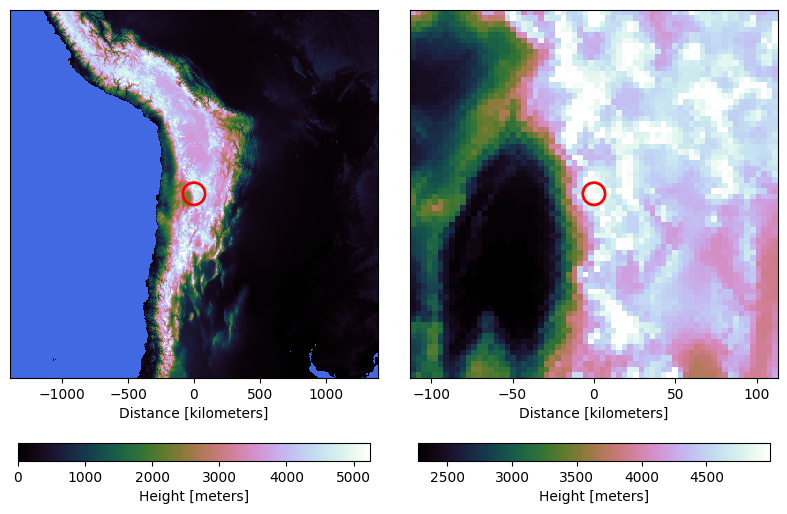

In [3]:
site = maria.get_site("llano_de_chajnantor", altitude=5065)

print(site)
site.plot()

Here the `fetch` function downloads a map to the path `map_filename`, but `map_filename` can be any `.h5` or `.fits` file of an image that corresponds to the `maria` map convention (see [Maps](https://thomaswmorris.com/maria/usage/inputs/maps)). Additional kwargs added to the `maria.map.load` overwrite the metadata of the loaded map.

2025-11-23 21:34:46.465 INFO: Fetching https://github.com/thomaswmorris/maria-data/raw/master/maps/cluster1.fits


Downloading:   0%|                | 0.00/4.20M [00:00<?, ?B/s]

Downloading: 100%|████████████████| 4.20M/4.20M [00:00<00:00, 86.2MB/s]

ProjectionMap:
  shape(nu, y, x): (1, 1024, 1024)
  stokes: naive
  nu: [150.] GHz
  t: naive
  z: naive
  quantity: spectral_flux_density_per_pixel
  units: Jy/pixel
    min: -1.923e-04
    max: -2.502e-07
    rms: 2.900e-05
  center:
    ra: 19ʰ24ᵐ37.44ˢ
    dec: -31°13’48.00”
  size(y, x): (1°, 1°)
  resolution(y, x): (3.516”, 3.516”)
  beam(maj, min, rot): [[0. 0. 0.]] rad
  memory: 16.78 MB


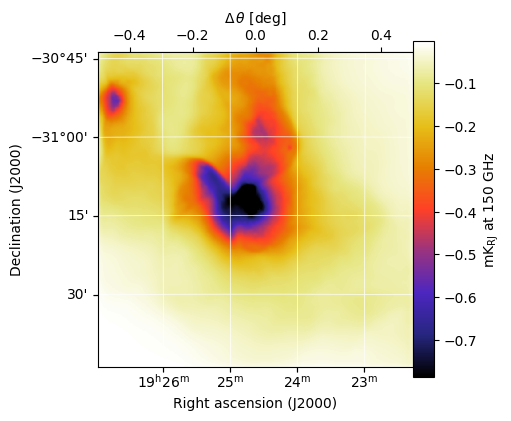

In [4]:
from maria.io import fetch

map_filename = fetch("maps/cluster1.fits")

input_map = maria.map.load(
    filename=map_filename,
    nu=150e9,
    center=(291.156, -31.23))
input_map.data *= 5e1 

print(input_map)
input_map.to("K_RJ").plot()

We plan an observation using the `Planner`, which ensures that a given `target` as seen by a given `site` will be high enough above the horizon.

PlanList(2 plans, 1200 s):
                           start_time duration     target(ra,dec)     center(az,el)
chunk                                                                              
0      2024-08-07 01:31:15.000 +00:00    600 s  (291.2°, -31.23°)  (119.7°, 71.13°)
1      2024-08-07 01:41:52.500 +00:00    600 s  (291.2°, -31.23°)  (122.6°, 73.23°)


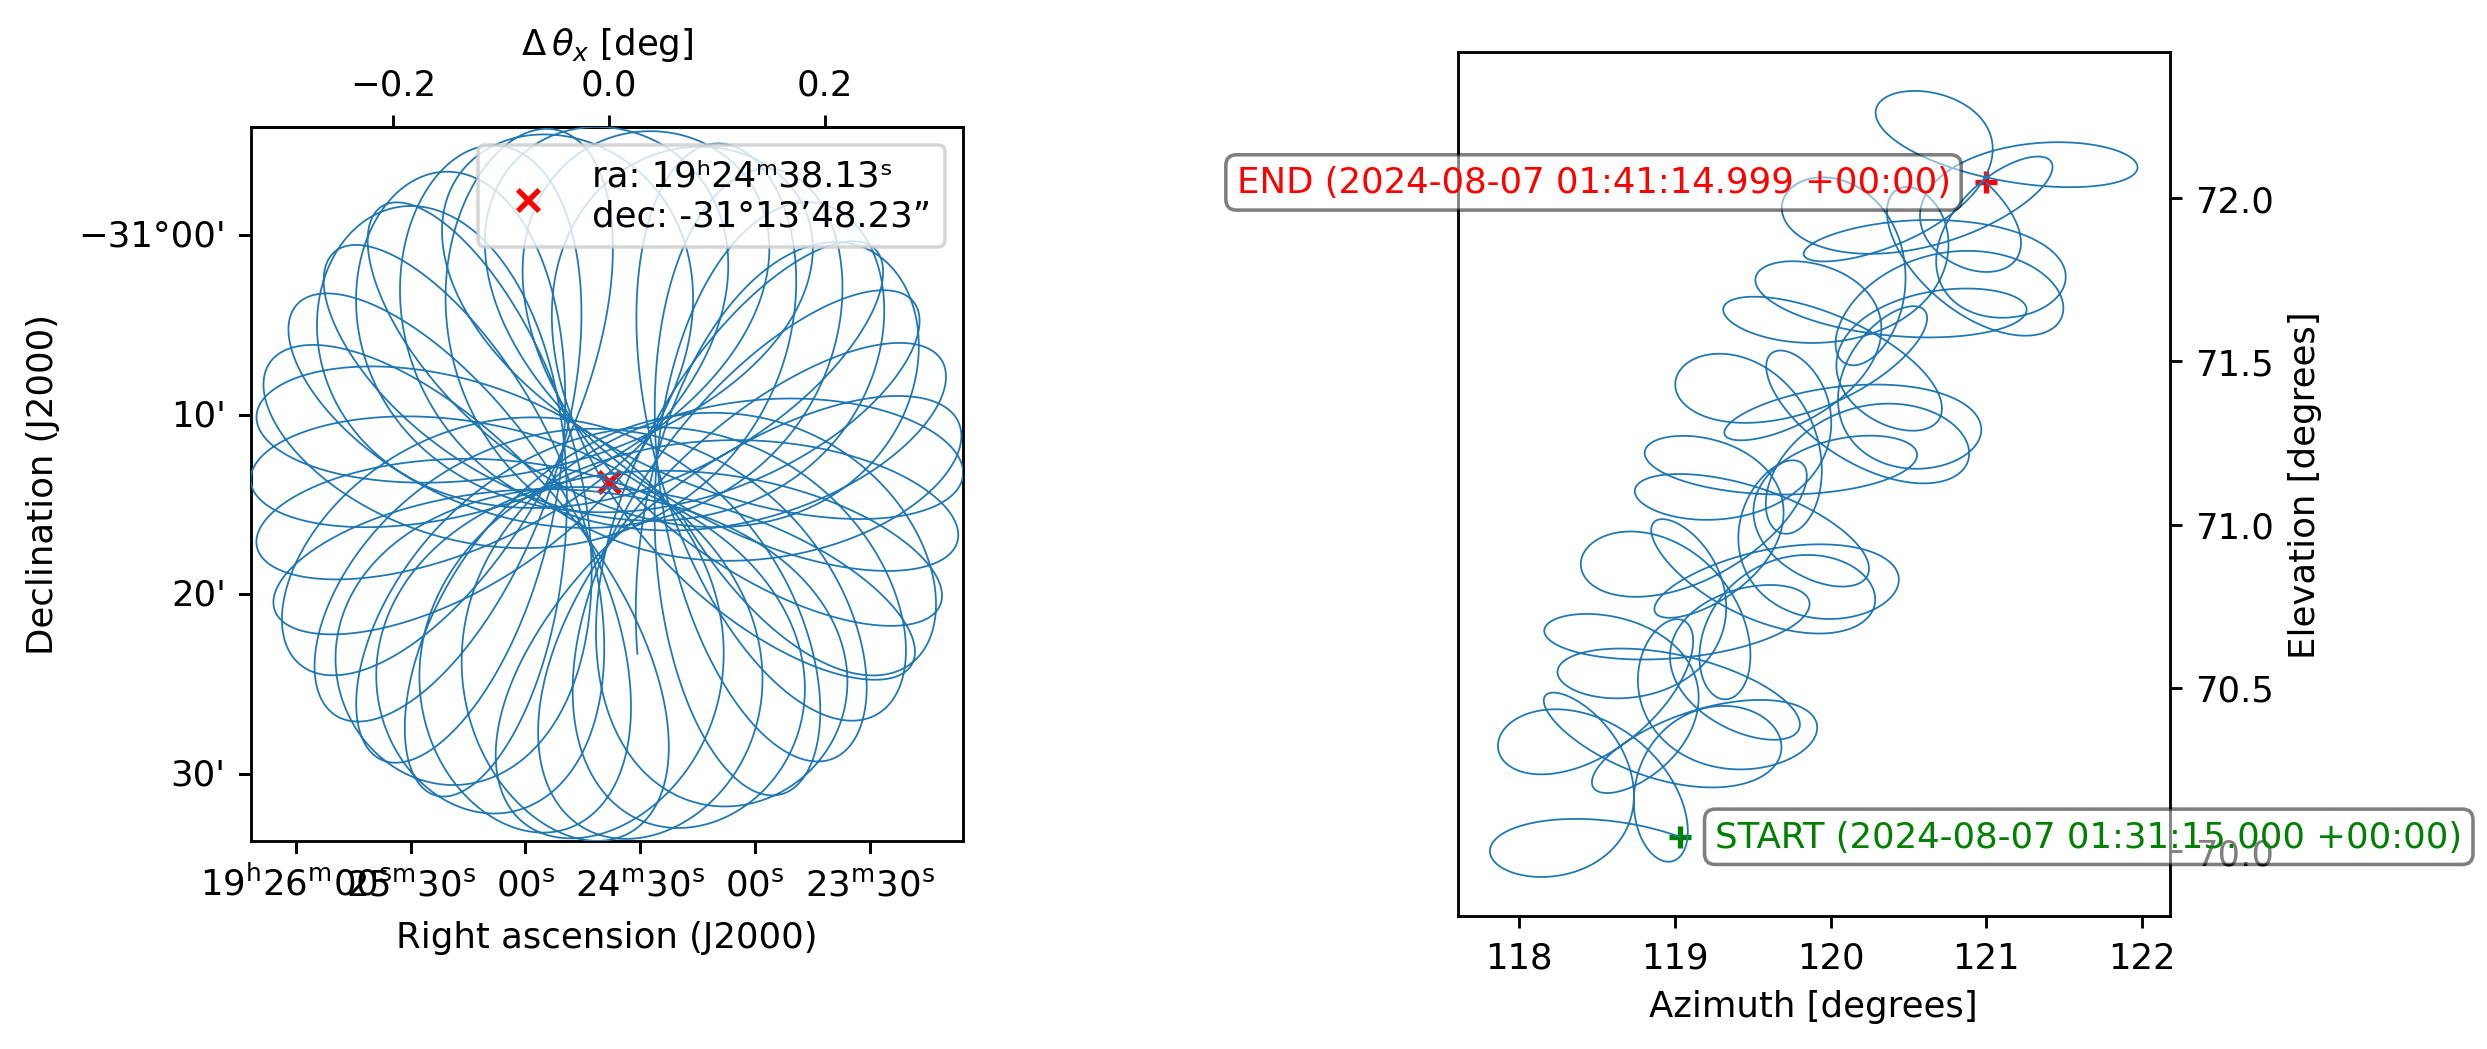

In [5]:
from maria import Planner

planner = Planner(start_time="2024-08-06T03:00:00",
                  target=input_map, 
                  site=site, 
                  constraints={"el": (70, 90)})

plans = planner.generate_plans(total_duration=1200,  # in seconds
                               max_chunk_duration=600,  # in seconds
                               scan_pattern="daisy",
                               scan_options={"radius": input_map.width.deg / 3},
                               sample_rate=10)

print(plans)
plans[0].plot()

In [6]:
sim = maria.Simulation(
    instrument,
    plans=plans,
    site=site,
    atmosphere="2d",
    atmosphere_kwargs={"weather": {"pwv": 0.5}},
    map=input_map)

print(sim)

2025-11-23 21:35:06.198 INFO: Fetching https://github.com/thomaswmorris/maria-data/raw/master/atmosphere/spectra/am/v3/chajnantor.h5


Downloading:   0%|                | 0.00/32.9M [00:00<?, ?B/s]

Downloading:  45%|███████▏        | 14.8M/32.9M [00:00<00:00, 148MB/s]

Downloading: 100%|████████████████| 32.9M/32.9M [00:00<00:00, 168MB/s]

2025-11-23 21:35:07.861 INFO: Fetching https://github.com/thomaswmorris/maria-data/raw/master/atmosphere/weather/era5/chajnantor.h5


Downloading:   0%|                | 0.00/8.00M [00:00<?, ?B/s]

Downloading: 100%|████████████████| 8.00M/8.00M [00:00<00:00, 121MB/s]

Simulation
├ Instrument(1 array)
│ ├ arrays:
│ │             n      FOV baseline        bands polarized
│ │  array1  1798  0.4957°      0 m  [f090,f150]     False
│ │ 
│ └ bands:
│       name   center   width    η         NEP      NET_RJ         NET_CMB     FWHM
│    0  f090   90 GHz  20 GHz  0.5  5.445 aW√s  40 uK_RJ√s  49.13 uK_CMB√s  0.5832’
│    1  f150  150 GHz  30 GHz  0.5  12.25 aW√s  60 uK_RJ√s    104 uK_CMB√s  0.3499’
├ Site:
│   region: chajnantor
│   timezone: America/Santiago
│   location:
│     longitude: 67°45’17.28” W
│     latitude:  23°01’45.84” S
│     altitude: 5065 m
│   seasonal: True
│   diurnal: True
├ PlanList(2 plans, 1200 s):
│                            start_time duration     target(ra,dec)     center(az,el)
│ chunk                                                                              
│ 0      2024-08-07 01:31:15.000 +00:00    600 s  (291.2°, -31.23°)  (119.7°, 71.13°)
│ 1      2024-08-07 01:41:52.500 +00:00    600 s  (291.2°, -31.23°)  (122.6°, 73.2

We run the simulation, which spits out a `TOD` object (which stands for time-ordered data). We can then plot the `TOD`:

2025-11-23 21:35:09.433 INFO: Simulating observation 1 of 2


Constructing atmosphere:   0%|                | 0/8 [00:00<?, ?it/s]

Constructing atmosphere:  12%|██              | 1/8 [00:00<00:05,  1.28it/s]

Constructing atmosphere:  25%|████            | 2/8 [00:01<00:04,  1.31it/s]

Constructing atmosphere:  38%|██████          | 3/8 [00:02<00:04,  1.22it/s]

Constructing atmosphere:  50%|████████        | 4/8 [00:03<00:03,  1.23it/s]

Constructing atmosphere:  62%|██████████      | 5/8 [00:03<00:02,  1.30it/s]

Constructing atmosphere:  75%|████████████    | 6/8 [00:04<00:01,  1.33it/s]

Constructing atmosphere:  88%|██████████████  | 7/8 [00:05<00:00,  1.29it/s]

Constructing atmosphere: 100%|████████████████| 8/8 [00:06<00:00,  1.32it/s]

Constructing atmosphere: 100%|████████████████| 8/8 [00:06<00:00,  1.30it/s]

Generating turbulence:   0%|                | 0/8 [00:00<?, ?it/s]

Generating turbulence:  25%|████            | 2/8 [00:00<00:00, 15.97it/s]

Generating turbulence:  50%|████████        | 4/8 [00:00<00:00, 12.31it/s]

Generating turbulence:  75%|████████████    | 6/8 [00:00<00:00,  8.98it/s]

Generating turbulence: 100%|████████████████| 8/8 [00:01<00:00,  6.19it/s]

Generating turbulence: 100%|████████████████| 8/8 [00:01<00:00,  7.37it/s]

Sampling turbulence:   0%|                | 0/8 [00:00<?, ?it/s]

Sampling turbulence:  12%|██              | 1/8 [00:01<00:13,  1.95s/it]

Sampling turbulence:  25%|████            | 2/8 [00:03<00:09,  1.51s/it]

Sampling turbulence:  38%|██████          | 3/8 [00:04<00:06,  1.31s/it]

Sampling turbulence:  50%|████████        | 4/8 [00:05<00:04,  1.22s/it]

Sampling turbulence:  62%|██████████      | 5/8 [00:06<00:03,  1.17s/it]

Sampling turbulence:  75%|████████████    | 6/8 [00:07<00:02,  1.14s/it]

Sampling turbulence:  88%|██████████████  | 7/8 [00:08<00:01,  1.17s/it]

Sampling turbulence: 100%|████████████████| 8/8 [00:09<00:00,  1.17s/it]

Sampling turbulence: 100%|████████████████| 8/8 [00:09<00:00,  1.24s/it]

Computing atmospheric emission:   0%|                | 0/2 [00:00<?, ?it/s]

Computing atmospheric emission:   0%|                | 0/2 [00:00<?, ?it/s, band=f090]

Computing atmospheric emission:  50%|████████        | 1/2 [00:01<00:01,  1.97s/it, band=f090]

Computing atmospheric emission:  50%|████████        | 1/2 [00:01<00:01,  1.97s/it, band=f150]

Computing atmospheric emission: 100%|████████████████| 2/2 [00:02<00:00,  1.19s/it, band=f150]

Computing atmospheric emission: 100%|████████████████| 2/2 [00:02<00:00,  1.31s/it, band=f150]

Sampling map:   0%|                | 0/2 [00:00<?, ?it/s, band=, channel=, stokes=]

Sampling map:   0%|                | 0/2 [00:00<?, ?it/s, band=f090]               

Sampling map:  50%|████████        | 1/2 [00:04<00:04,  4.04s/it, band=f090]

Sampling map:  50%|████████        | 1/2 [00:04<00:04,  4.04s/it, band=f150]

Sampling map: 100%|████████████████| 2/2 [00:06<00:00,  3.19s/it, band=f150]

Sampling map: 100%|████████████████| 2/2 [00:06<00:00,  3.32s/it, band=f150]

Generating noise:   0%|                | 0/2 [00:00<?, ?it/s]

Generating noise:   0%|                | 0/2 [00:00<?, ?it/s, band=f090]

Generating noise:  50%|████████        | 1/2 [00:00<00:00,  2.19it/s, band=f090]

Generating noise:  50%|████████        | 1/2 [00:00<00:00,  2.19it/s, band=f150]

Generating noise: 100%|████████████████| 2/2 [00:00<00:00,  3.70it/s, band=f150]

Generating noise: 100%|████████████████| 2/2 [00:00<00:00,  3.35it/s, band=f150]

2025-11-23 21:35:44.218 INFO: Simulated observation 1 of 2 in 34.77 s


2025-11-23 21:35:44.218 INFO: Simulating observation 2 of 2


Constructing atmosphere:   0%|                | 0/8 [00:00<?, ?it/s]

Constructing atmosphere:  12%|██              | 1/8 [00:00<00:04,  1.62it/s]

Constructing atmosphere:  25%|████            | 2/8 [00:01<00:03,  1.54it/s]

Constructing atmosphere:  38%|██████          | 3/8 [00:01<00:03,  1.56it/s]

Constructing atmosphere:  50%|████████        | 4/8 [00:02<00:02,  1.59it/s]

Constructing atmosphere:  62%|██████████      | 5/8 [00:03<00:01,  1.59it/s]

Constructing atmosphere:  75%|████████████    | 6/8 [00:03<00:01,  1.61it/s]

Constructing atmosphere:  88%|██████████████  | 7/8 [00:04<00:00,  1.59it/s]

Constructing atmosphere: 100%|████████████████| 8/8 [00:05<00:00,  1.49it/s]

Constructing atmosphere: 100%|████████████████| 8/8 [00:05<00:00,  1.54it/s]

Generating turbulence:   0%|                | 0/8 [00:00<?, ?it/s]

Generating turbulence:  25%|████            | 2/8 [00:00<00:00, 15.91it/s]

Generating turbulence:  50%|████████        | 4/8 [00:00<00:00, 12.27it/s]

Generating turbulence:  75%|████████████    | 6/8 [00:00<00:00,  8.97it/s]

Generating turbulence: 100%|████████████████| 8/8 [00:01<00:00,  6.23it/s]

Generating turbulence: 100%|████████████████| 8/8 [00:01<00:00,  7.40it/s]

Sampling turbulence:   0%|                | 0/8 [00:00<?, ?it/s]

Sampling turbulence:  12%|██              | 1/8 [00:02<00:14,  2.10s/it]

Sampling turbulence:  25%|████            | 2/8 [00:03<00:09,  1.55s/it]

Sampling turbulence:  38%|██████          | 3/8 [00:04<00:06,  1.34s/it]

Sampling turbulence:  50%|████████        | 4/8 [00:05<00:04,  1.25s/it]

Sampling turbulence:  62%|██████████      | 5/8 [00:06<00:03,  1.23s/it]

Sampling turbulence:  75%|████████████    | 6/8 [00:07<00:02,  1.18s/it]

Sampling turbulence:  88%|██████████████  | 7/8 [00:08<00:01,  1.17s/it]

Sampling turbulence: 100%|████████████████| 8/8 [00:10<00:00,  1.17s/it]

Sampling turbulence: 100%|████████████████| 8/8 [00:10<00:00,  1.26s/it]

Computing atmospheric emission:   0%|                | 0/2 [00:00<?, ?it/s]

Computing atmospheric emission:   0%|                | 0/2 [00:00<?, ?it/s, band=f090]

Computing atmospheric emission:  50%|████████        | 1/2 [00:01<00:01,  1.78s/it, band=f090]

Computing atmospheric emission:  50%|████████        | 1/2 [00:01<00:01,  1.78s/it, band=f150]

Computing atmospheric emission: 100%|████████████████| 2/2 [00:02<00:00,  1.06s/it, band=f150]

Computing atmospheric emission: 100%|████████████████| 2/2 [00:02<00:00,  1.17s/it, band=f150]

Sampling map:   0%|                | 0/2 [00:00<?, ?it/s, band=, channel=, stokes=]

Sampling map:   0%|                | 0/2 [00:00<?, ?it/s, band=f090]               

Sampling map:  50%|████████        | 1/2 [00:02<00:02,  2.31s/it, band=f090]

Sampling map:  50%|████████        | 1/2 [00:02<00:02,  2.31s/it, band=f150]

Sampling map: 100%|████████████████| 2/2 [00:04<00:00,  2.29s/it, band=f150]

Sampling map: 100%|████████████████| 2/2 [00:04<00:00,  2.30s/it, band=f150]

Generating noise:   0%|                | 0/2 [00:00<?, ?it/s]

Generating noise:   0%|                | 0/2 [00:00<?, ?it/s, band=f090]

Generating noise:  50%|████████        | 1/2 [00:00<00:00,  6.90it/s, band=f090]

Generating noise:  50%|████████        | 1/2 [00:00<00:00,  6.90it/s, band=f150]

Generating noise: 100%|████████████████| 2/2 [00:00<00:00,  6.69it/s, band=f150]

Generating noise: 100%|████████████████| 2/2 [00:00<00:00,  6.71it/s, band=f150]

2025-11-23 21:36:15.535 INFO: Simulated observation 2 of 2 in 31.3 s


[TOD(shape=(1798, 6000), fields=['atmosphere', 'map', 'noise'], units='K_RJ', start=2024-08-07 01:41:14.899 +00:00, duration=599.9s, sample_rate=10.0Hz, metadata={'atmosphere': True, 'sim_time': <Arrow [2025-11-23T21:35:38.824560+00:00]>, 'altitude': 5065.0, 'region': 'chajnantor', 'pwv': 0.5, 'base_temperature': 272.7}), TOD(shape=(1798, 6000), fields=['atmosphere', 'map', 'noise'], units='K_RJ', start=2024-08-07 01:51:52.399 +00:00, duration=599.9s, sample_rate=10.0Hz, metadata={'atmosphere': True, 'sim_time': <Arrow [2025-11-23T21:36:10.098820+00:00]>, 'altitude': 5065.0, 'region': 'chajnantor', 'pwv': 0.925, 'base_temperature': 272.683})]


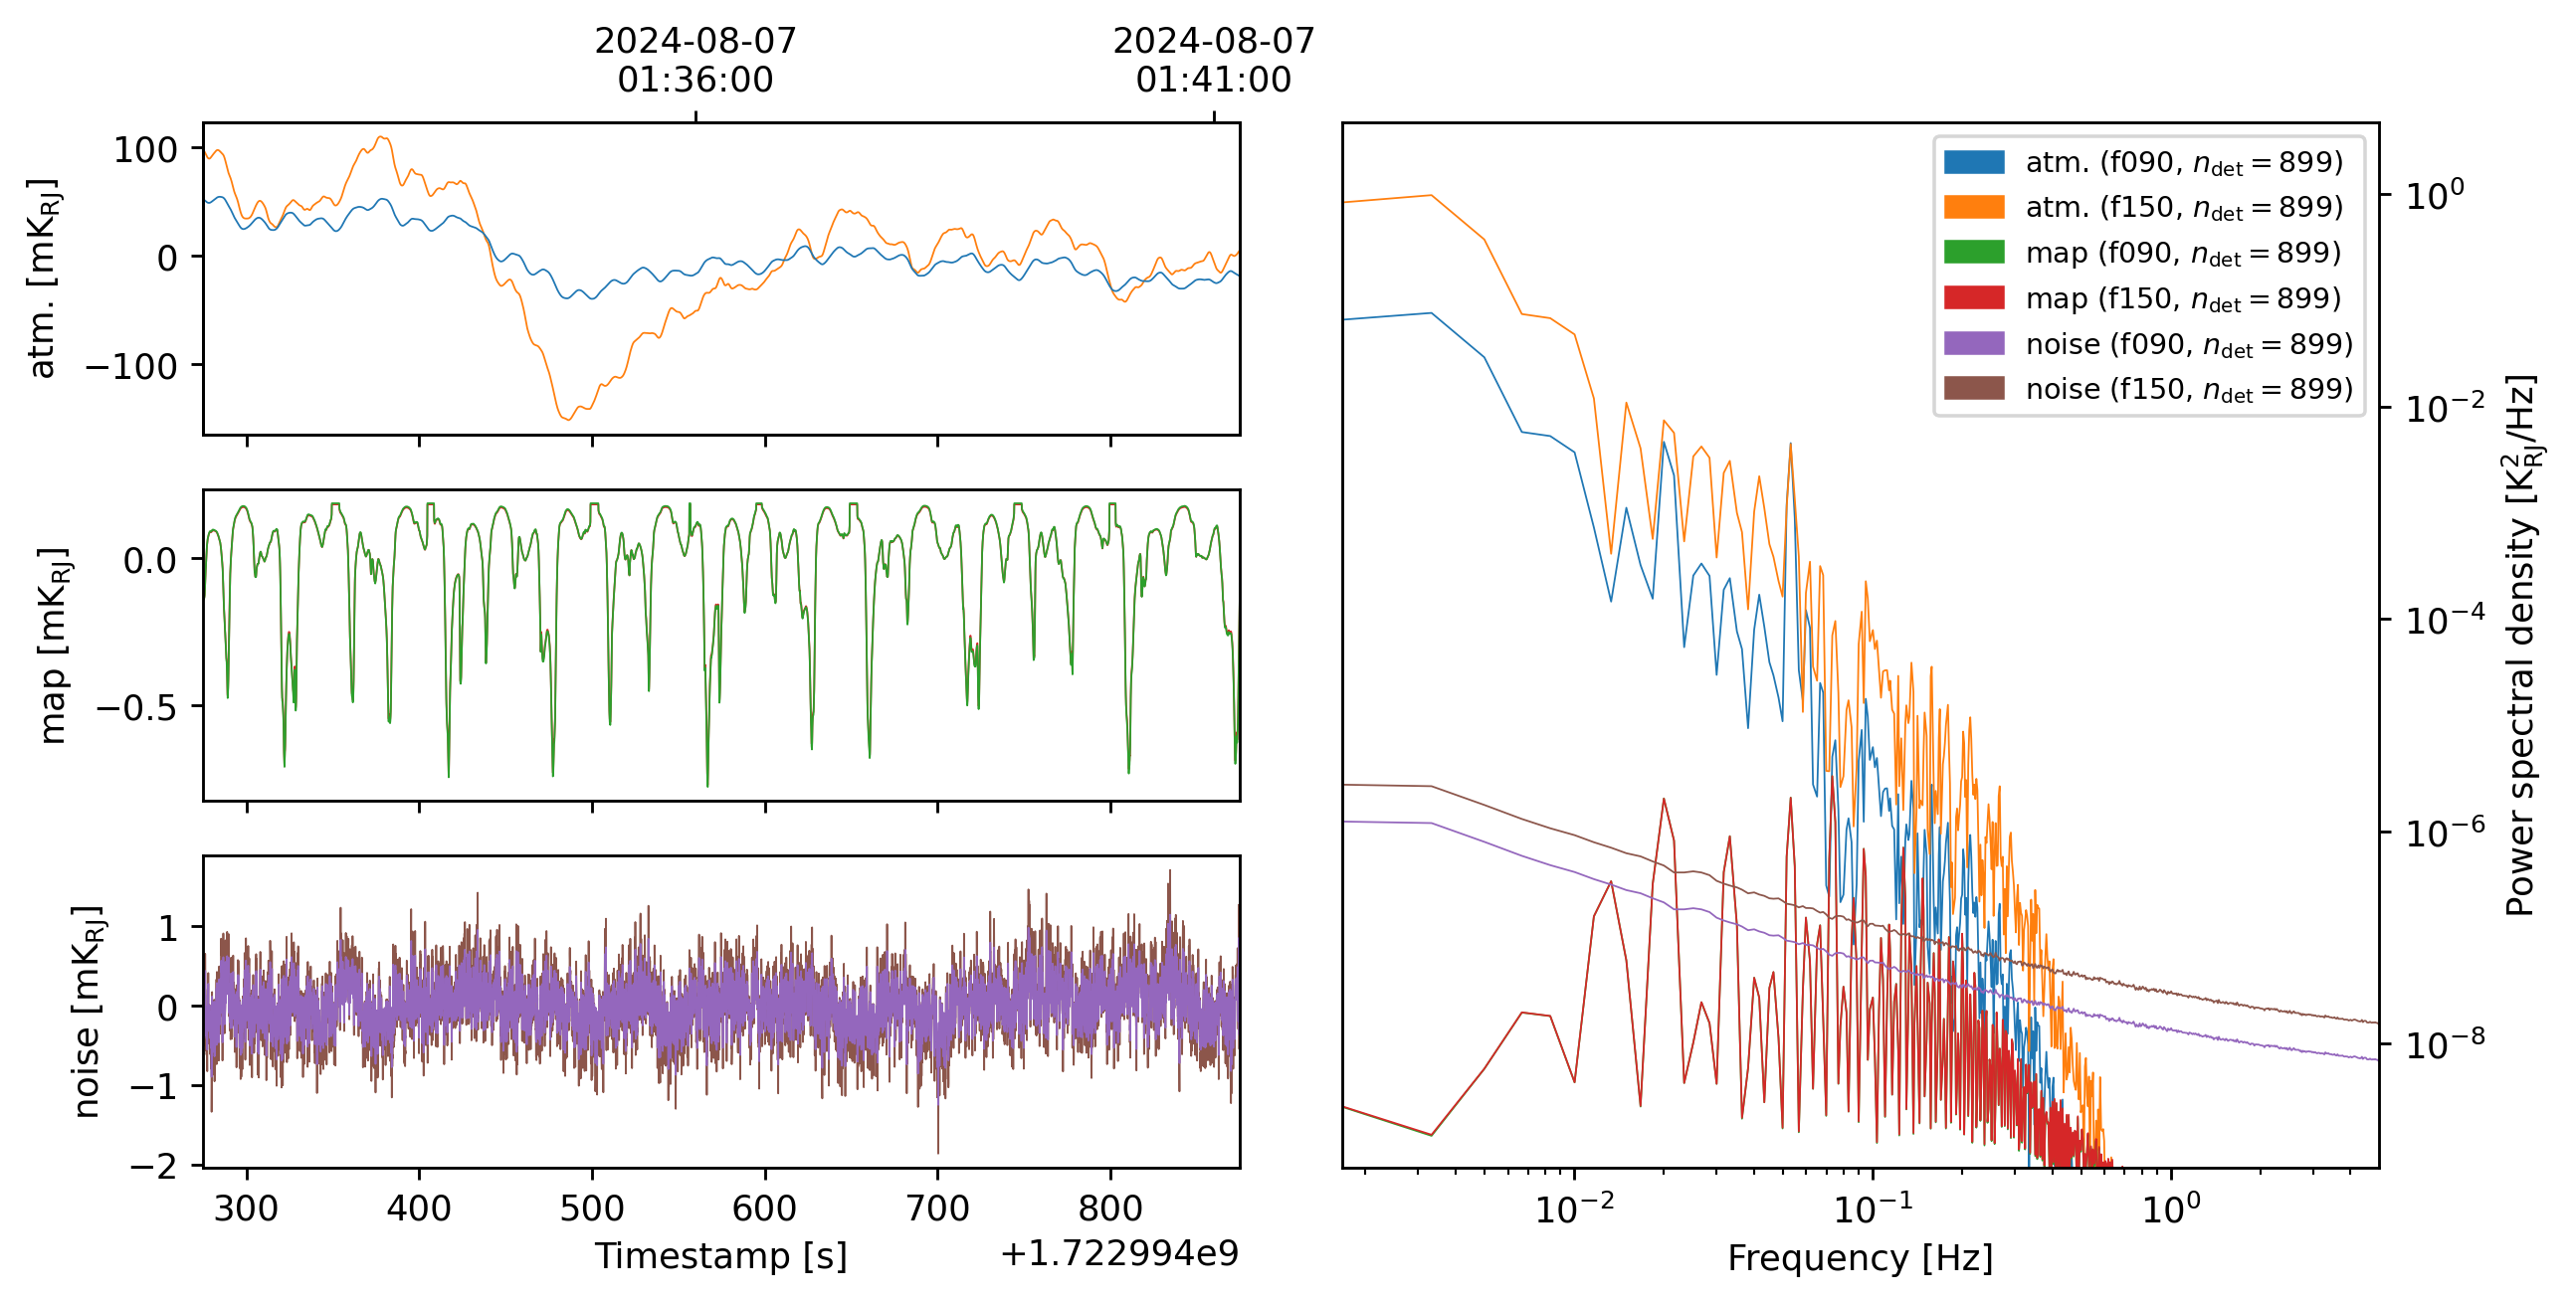

In [7]:
tods = sim.run()

print(tods)
tods[0].plot()

In [8]:
maria.undebug()

In [9]:
input_map.center

(291.2°, -31.23°)

We can then map the `TOD` using the built-in mapper.

In [10]:
from maria.mappers import BinMapper

mapper = BinMapper(
    # center=input_map.center,
    # frame="ra/dec",
    # width=input_map.width,
    # height=input_map.height,
    # resolution=input_map.width / 256,
    tod_preprocessing={
        "remove_spline": {"knot_spacing": 60, "remove_el_gradient": True},
        "remove_modes": {"modes_to_remove": 1},
    },
    map_postprocessing={
        "gaussian_filter": {"sigma": 1},
    },
    units="mK_RJ",
    tods=tods,
)

mapper.add_tods(tods)

output_map = mapper.run()

2025-11-23 21:36:23.670 INFO: Inferring center {'ra': '19ʰ24ᵐ38.02ˢ', 'dec': '-31°14’8.10”'} for mapper.


2025-11-23 21:36:23.684 INFO: Inferring mapper width 1.119° for mapper from observation patch.


2025-11-23 21:36:23.685 INFO: Inferring mapper height 1.119° to match supplied width.


2025-11-23 21:36:23.698 INFO: Inferring mapper resolution 0.5245’ for mapper from observation patch.


2025-11-23 21:36:23.700 INFO: Inferring mapper stokes parameters 'I' for mapper.


Preprocessing TODs:   0%|                | 0/2 [00:00<?, ?it/s]

Preprocessing TODs:  50%|████████        | 1/2 [00:01<00:01,  1.17s/it]

Preprocessing TODs: 100%|████████████████| 2/2 [00:02<00:00,  1.18s/it]

Preprocessing TODs: 100%|████████████████| 2/2 [00:02<00:00,  1.17s/it]

Preprocessing TODs:   0%|                | 0/2 [00:00<?, ?it/s]

Preprocessing TODs:  50%|████████        | 1/2 [00:01<00:01,  1.08s/it]

Preprocessing TODs: 100%|████████████████| 2/2 [00:02<00:00,  1.09s/it]

Preprocessing TODs: 100%|████████████████| 2/2 [00:02<00:00,  1.09s/it]

Mapping:   0%|          | 0/4 [00:00<?, ?it/s, tod=1/4]

Mapping:  25%|██▌       | 1/4 [00:01<00:05,  1.70s/it, tod=1/4]

Mapping:  50%|█████     | 2/4 [00:03<00:03,  1.56s/it, tod=1/4]

Mapping:  75%|███████▌  | 3/4 [00:04<00:01,  1.42s/it, tod=1/4]

Mapping: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it, tod=1/4]

Mapping: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it, tod=1/4]

We can see the recovered map with

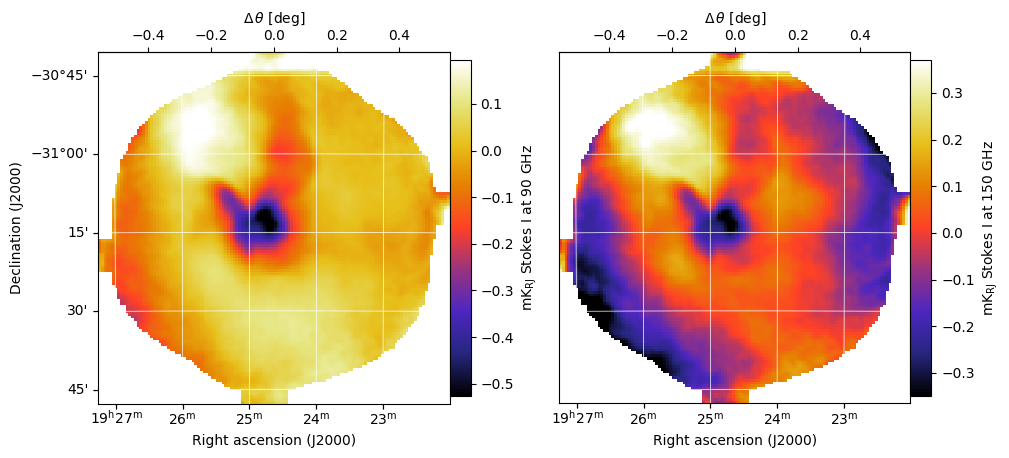

In [11]:
output_map.plot(nu_index=[0, 1])